## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [48]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6 * 9, 3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.


# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')
shape = None
board_size = (9, 6)
# Step through the list and search for chessboard corners
for fname in images:
    board_img = cv2.imread(fname)
    gray = cv2.cvtColor(board_img, cv2.COLOR_BGR2GRAY)

    shape = gray.shape[::-1] if shape is None else shape
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, board_size, None)

    # If found, add object points, image points
    if ret:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        #img = cv2.drawChessboardCorners(img, (9,6), corners, ret)

_, mtx, dist, _, _ = cv2.calibrateCamera(objpoints, imgpoints, shape, None, None)

def undistort(raw_image):
    return cv2.undistort(raw_image, mtx, dist, None, mtx)

def plot(raw_image, processed, processed_title="Processed", save_fig=False):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()

    ax1.set_title('Original', fontsize=50)
    if len(raw_image.shape) == 2:
        ax1.imshow(raw_image, cmap='gray')
    else:
        ax1.imshow(cv2.cvtColor(raw_image, cv2.COLOR_BGR2RGB))

    ax2.set_title(processed_title, fontsize=50)
    # No need to convert binary images
    if len(processed.shape) == 2:
        ax2.imshow(processed, cmap='gray')
    else:
        ax2.imshow(cv2.cvtColor(processed, cv2.COLOR_BGR2RGB))

    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

    if save_fig:
        plt.savefig(f"output_images/{processed_title.lower()}_comparison.png")

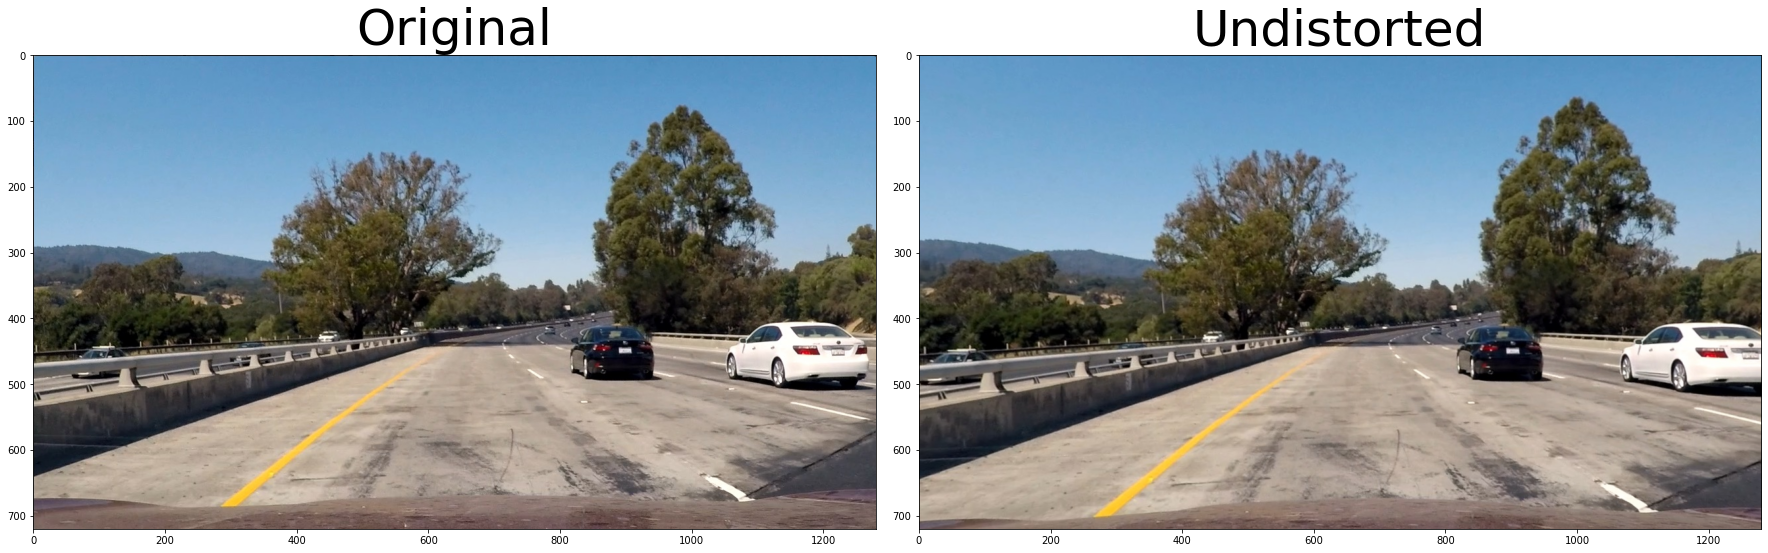

In [49]:
## Apply a distortion correction to raw images.

image = cv2.imread("test_images/test1.jpg")
undist = undistort(image)
plot(image, undist, "Undistorted", True)


In [50]:
def transform_color(undistorted_img, s_thresh=(200, 255), sx_thresh=(20, 100)):
    """Use L and S channels and gradient sabel threshold to get binary threshholded img"""

    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(undistorted_img, cv2.COLOR_BGR2HLS)
    s_channel = hls[:,:,2]

    # Sobel x
    gray = cv2.cvtColor(undistorted_img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255 * abs_sobelx / np.max(abs_sobelx))

    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1

    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    stacked_binary = np.dstack((np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    return stacked_binary, combined_binary

In [51]:
def transform_perspective(bin_image, reverse=False):
    """Transform the possible lane line regions into a bird eye view"""
    (height, width) = bin_image.shape[:2]

    # pick the region that most likely contains the lane lines in a trapezoid
    offset = 100
    src_region = np.float32([
        [width / 2 - offset + 40, height / 2 + offset],
        [width / 2 + offset - 30, height / 2 + offset],
        [width - offset - 50, height],
        [offset + 95, height],
    ])

    # leave enough space for curvature
    dest_region = np.float32([
        [offset + 95, 0],
        [width - offset - 50, 0],
        [width - offset - 50, height],
        [offset + 95, height],
     ])

    if reverse:
        trans_matrix = cv2.getPerspectiveTransform(dest_region, src_region)
    else:
        trans_matrix = cv2.getPerspectiveTransform(src_region, dest_region)

    return cv2.warpPerspective(bin_image, trans_matrix, (width, height), flags=cv2.INTER_LINEAR)


In [52]:
def find_lane_pixels_sliding_window(binary_warped, draw_sliding_window=False):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPER-PARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1) * window_height
        win_y_high = binary_warped.shape[0] - window * window_height

        # Find the four below boundaries of the window
        # each window's left and right boundary
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Draw the windows on the visualization image
        if draw_sliding_window:
            cv2.rectangle(out_img, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high),(0,255,0), 2)
            cv2.rectangle(out_img, (win_xright_low, win_y_low), (win_xright_high,win_y_high),(0,255,0), 2)

        ### Identify the nonzero pixels in x and y within the window ###
        # record the indexes of non zero elements in the left and right window and we can
        # later recover the element's indexes in the img array
        good_left_inds = [
            i
            for i in range(len(nonzerox))
                if win_xleft_low <= nonzerox[i] < win_xleft_high and win_y_low <= nonzeroy[i] < win_y_high
        ]
        good_right_inds = [
            i
            for i in range(len(nonzerox))
            if win_xright_low <= nonzerox[i] < win_xright_high and win_y_low <= nonzeroy[i] < win_y_high
        ]

        # Append these indices to the lists
        left_lane_inds.extend(good_left_inds)
        right_lane_inds.extend(good_right_inds)

        ### If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        leftx_current = np.int(np.mean(nonzerox[good_left_inds])) \
            if len(good_left_inds) > minpix else leftx_current
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))\
            if len(good_right_inds) > minpix else rightx_current

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty

def find_lane_pixels_around_poly(binary_warped, left_fit, right_fit, margin=100):
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    ### Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###

    # since the poly fit reverses x and y, we need pass in the reverse as well here
    # find all the 'x' values for all the nonzeroy
    left_lane_x = left_fit[0] * nonzeroy ** 2 + left_fit[1] * nonzeroy + left_fit[2]
    # range of possible x values
    left_lane_inds = np.array((left_lane_x - margin < nonzerox) & (left_lane_x + margin > nonzerox)).nonzero()[0]

    right_lane_x = right_fit[0] * nonzeroy ** 2 + right_fit[1] * nonzeroy + right_fit[2]
    right_lane_inds = np.array((right_lane_x - margin <= nonzerox) & (right_lane_x + margin > nonzerox)).nonzero()[0]

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty

def fit_poly(img_shape, leftx, lefty, rightx, righty):

    ### Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])

    ### Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]

    return left_fit, right_fit, left_fitx, right_fitx, ploty


# store the run's prev polyfit
prev_left_fit = []
prev_right_fit = []

def fit_polynomial(binary_warped, decorate_orig=False):
    """fit polynomial and calculate radius of curvature"""

    # Find our lane pixels first
    global prev_left_fit, prev_right_fit
    if len(prev_left_fit) == 0 or len(prev_right_fit) == 0:
        leftx, lefty, rightx, righty = find_lane_pixels_sliding_window(binary_warped, draw_sliding_window=True)
    else:
        leftx, lefty, rightx, righty = find_lane_pixels_around_poly(binary_warped, prev_left_fit, prev_right_fit)

    left_fit, right_fit, left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    prev_left_fit = left_fit
    prev_right_fit = right_fit

    # convert input binary image to 3 channels so we can mark with colors
    polyfit_img = np.dstack([binary_warped, binary_warped, binary_warped]) * 255

    # Colors in the left and right lane regions
    if decorate_orig:
        polyfit_img[lefty, leftx] = [255, 0, 0]
        polyfit_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    boundary_color = (0, 255, 255)
    left_fit_pts = np.dstack((np.array(left_fitx, np.int32), np.array(ploty, np.int32)))
    right_fit_pts = np.dstack((np.array(right_fitx, np.int32), np.array(ploty, np.int32)))
    cv2.polylines(polyfit_img, left_fit_pts,
                  False, boundary_color, thickness=30)
    cv2.polylines(polyfit_img, right_fit_pts,
                  False, boundary_color, thickness=30)

    # use the poly fitted lines as the bounds for fillPoly
    boundary_pts = np.int32([ np.concatenate([left_fit_pts[0], right_fit_pts[0][::-1]]) ])
    cv2.fillPoly(polyfit_img, boundary_pts, (0, 200, 0))

    return polyfit_img, leftx, lefty, rightx, righty, ploty, left_fitx, right_fitx

def draw_curvature_stats(img, leftx, lefty, rightx, righty, ploty, left_fitx, right_fitx, xm_per_pix=3.7/700, ym_per_pix=30.0/720):
    """Calculate lane curvature radius"""

    left_fit_cr = np.polyfit(lefty * ym_per_pix, leftx * xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty * ym_per_pix, rightx * xm_per_pix, 2)
    ploty_cr = ploty * ym_per_pix

    left_curverad = np.power(1 + (2 * left_fit_cr[0] * max(ploty_cr) + left_fit_cr[1]) ** 2, 3/2) / np.abs(2 * left_fit_cr[0])
    right_curverad = np.power(1 + (2 * right_fit_cr[0] * max(ploty_cr) + right_fit_cr[1]) ** 2, 3/2) / np.abs(2 * right_fit_cr[0])

    global prev_right_fit, prev_left_fit
    center_offset_meters = ((right_fitx[-1] + left_fitx[-1]) / 2 - img.shape[1] / 2) * xm_per_pix

    cv2.putText(
        img,
        f"Radius of Lane Curvature(m): left {left_curverad:.0f}, right {right_curverad:.0f}",
        org=(0, 50),
        fontFace=1,
        fontScale=3,
        color=(255, 255, 0),
        thickness=2,
    )
    cv2.putText(
        img,
        f"Lane Center Offset(m) {center_offset_meters:.2f}",
        org=(0, 100),
        fontFace=1,
        fontScale=3,
        color=(255, 255, 0),
        thickness=2,
    )


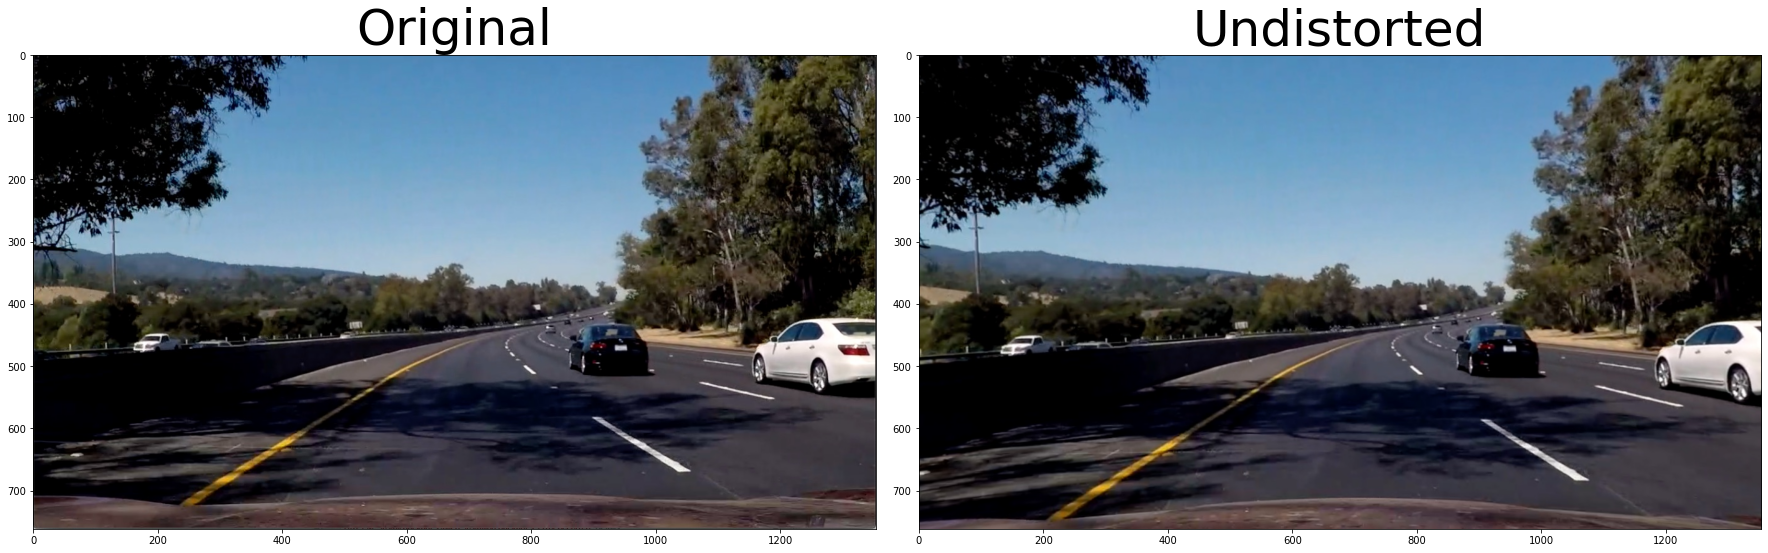

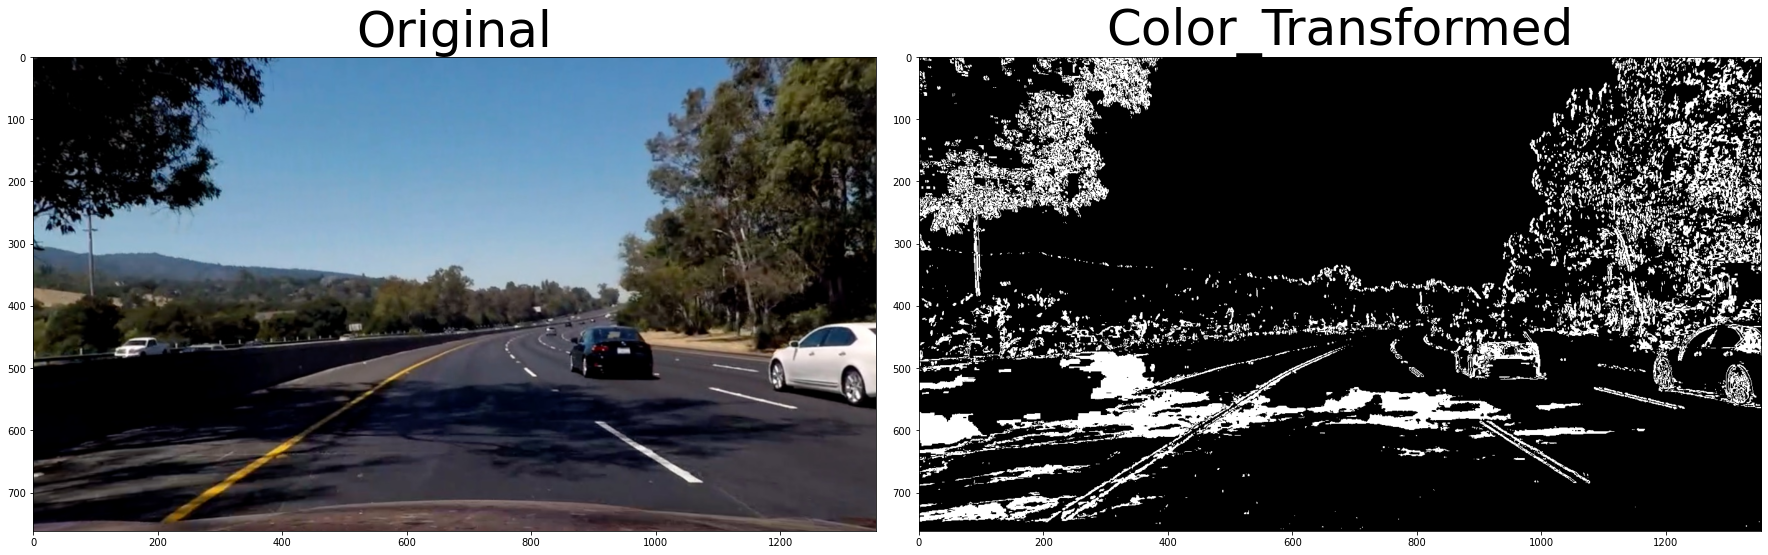

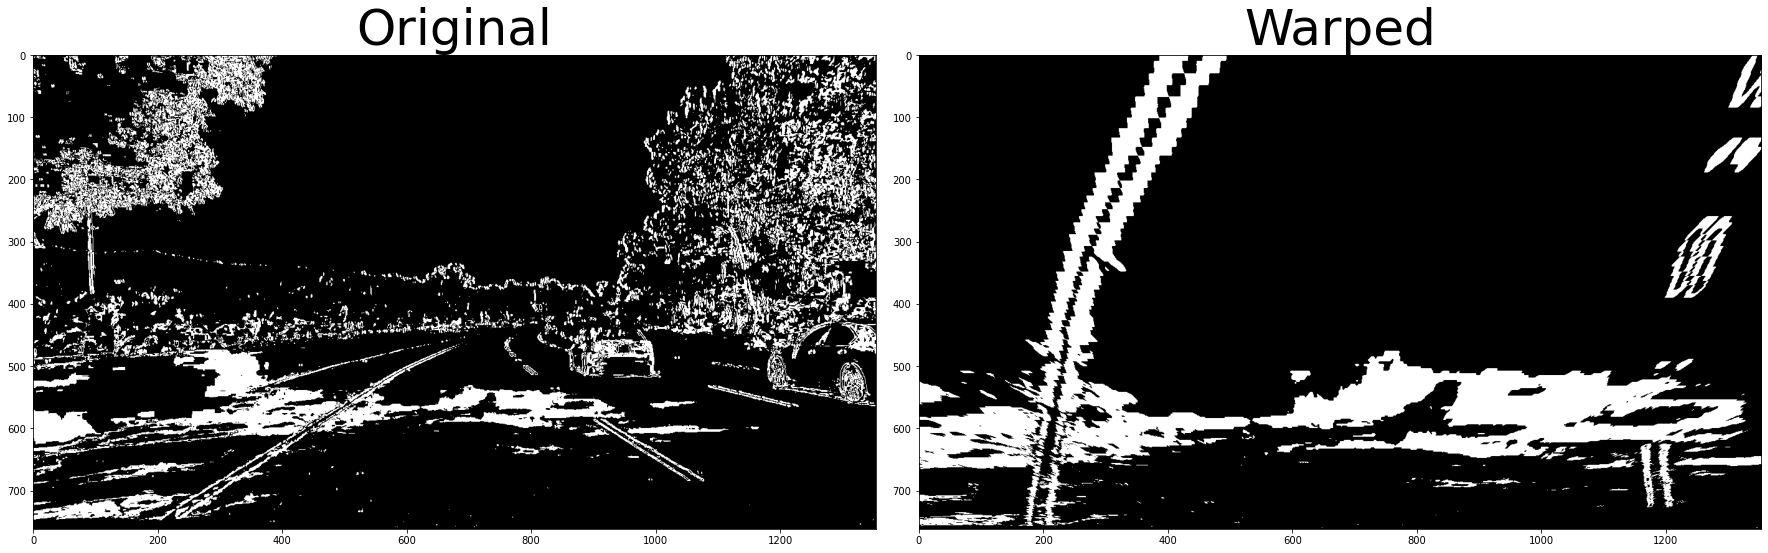

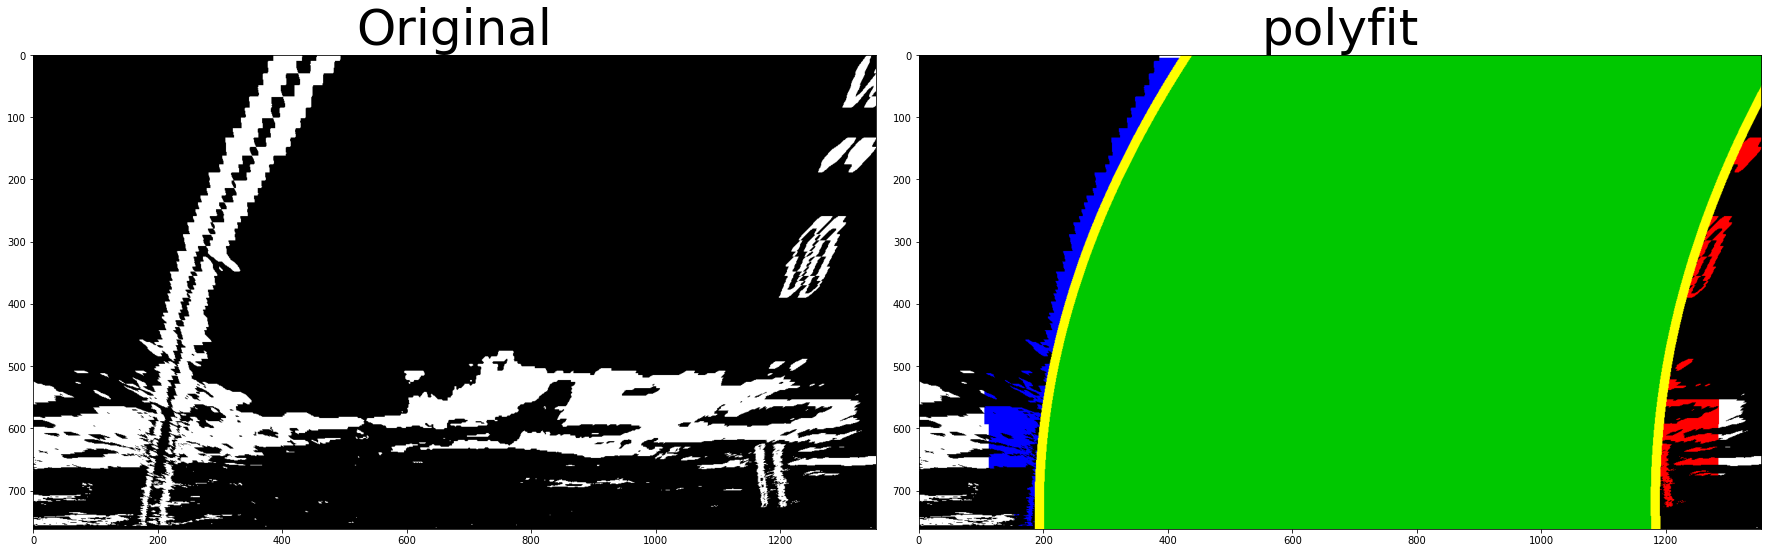

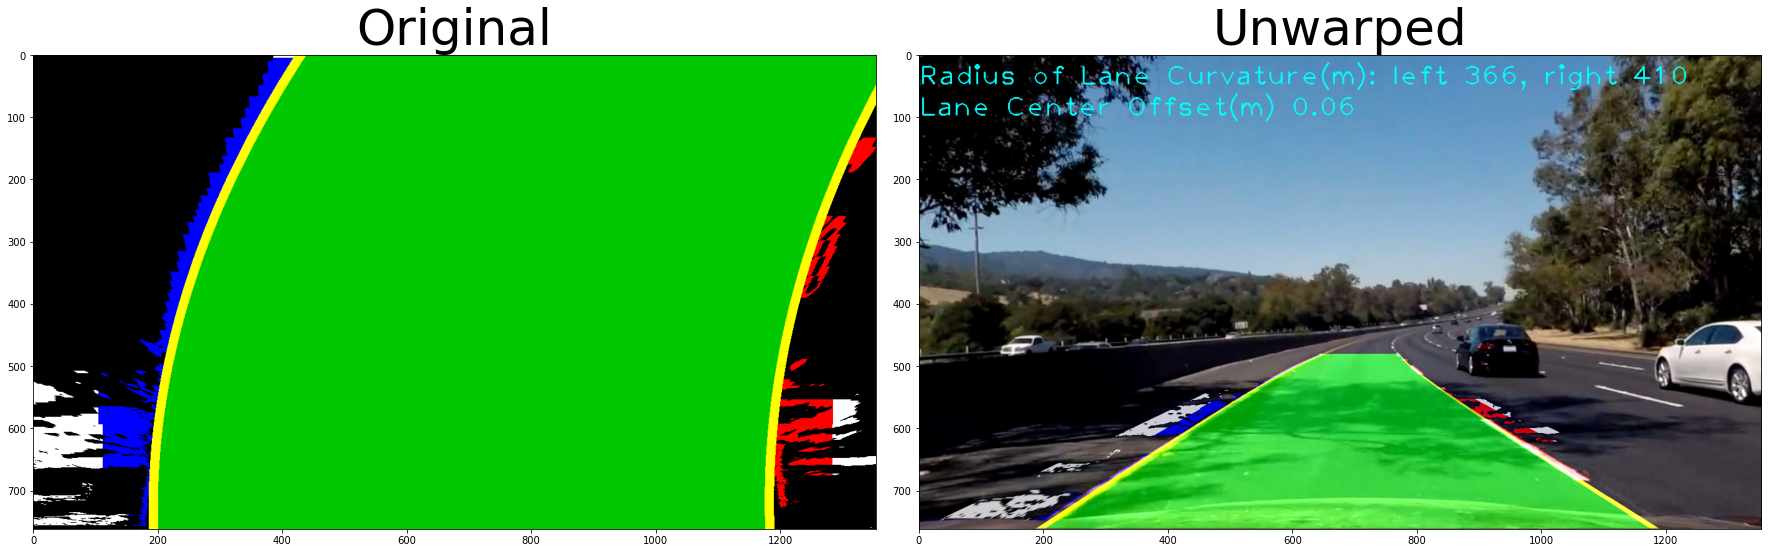

In [53]:
def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    The result image is computed as follows:

    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

def find_lane_line(img, should_plot=False, should_save_fig=False):
    undist = undistort(img)
    plot(img, undist, "Undistorted", should_save_fig) if should_plot else None

    stacked_binary, combined_binary = transform_color(undist)
    plot(undist, combined_binary, "Color_Transformed", should_save_fig) if should_plot else None

    warped = transform_perspective(combined_binary)
    plot(combined_binary, warped, "Warped", should_save_fig) if should_plot else None

    # Combine sliding window and prev poly match
    polyfit_img, leftx, lefty, rightx, righty, ploty, left_fitx, right_fitx = fit_polynomial(warped, True)
    plot(warped, polyfit_img, "polyfit", should_save_fig) if should_plot else None

    # Draw curvature radius and shift from center
    draw_curvature_stats(undist, leftx, lefty, rightx, righty, ploty, left_fitx, right_fitx)

    # decorate
    unwrap = transform_perspective(polyfit_img, True)
    merged = weighted_img(undist, unwrap)

    plot(polyfit_img, merged, "Unwarped", should_save_fig)  if should_plot else None

    return merged

paths = ["test_images/tree_shades.jpg"]
for path in paths:
    find_lane_line(cv2.imread(path), should_plot=True, should_save_fig=True)

In [55]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

vid = "project_video.mp4"
clip1 = VideoFileClip(vid)

white_clip = clip1.fl_image(find_lane_line)
white_clip.write_videofile("output_images/" + vid.replace(".mp4", "_lane_marked.mp4"), audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{}">
</video>
""".format(clip1))

Moviepy - Building video output_images/project_video_lane_marked.mp4.
Moviepy - Writing video output_images/project_video_lane_marked.mp4

Moviepy - Done !
Moviepy - video ready output_images/project_video_lane_marked.mp4
